In [1092]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import datetime
import math

from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from xgboost.sklearn import XGBRegressor

warnings.filterwarnings('ignore')

In [1093]:
df = pd.read_csv('books.csv', on_bad_lines='warn')

In [1094]:
df.shape

(11127, 12)

In [1095]:
df.dtypes

bookID                  int64
title                  object
authors                object
average_rating        float64
isbn                   object
isbn13                  int64
language_code          object
  num_pages             int64
ratings_count           int64
text_reviews_count      int64
publication_date       object
publisher              object
dtype: object

In [1096]:
df.head(5)

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,0439785960,9780439785969,eng,652,2095690,27591,9/16/2006,Scholastic Inc.
1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,0439358078,9780439358071,eng,870,2153167,29221,9/1/2004,Scholastic Inc.
2,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,0439554896,9780439554893,eng,352,6333,244,11/1/2003,Scholastic
3,5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56,043965548X,9780439655484,eng,435,2339585,36325,5/1/2004,Scholastic Inc.
4,8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling/Mary GrandPré,4.78,0439682584,9780439682589,eng,2690,41428,164,9/13/2004,Scholastic


In [1097]:
# check basic features and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11127 entries, 0 to 11126
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   bookID              11127 non-null  int64  
 1   title               11127 non-null  object 
 2   authors             11127 non-null  object 
 3   average_rating      11127 non-null  float64
 4   isbn                11127 non-null  object 
 5   isbn13              11127 non-null  int64  
 6   language_code       11127 non-null  object 
 7     num_pages         11127 non-null  int64  
 8   ratings_count       11127 non-null  int64  
 9   text_reviews_count  11127 non-null  int64  
 10  publication_date    11127 non-null  object 
 11  publisher           11127 non-null  object 
dtypes: float64(1), int64(5), object(6)
memory usage: 1.0+ MB


In [1098]:
df.rename(columns={"  num_pages": "num_pages"},inplace=True)

In [1099]:
## Delete column isbn & isbn13 because this is id and it is useless for prediction
df.drop(columns=['isbn','isbn13'],inplace=True)

## Data Cleaning

In [1100]:
# check for doublications
df.duplicated().any()

False

In [1101]:
100*(df.isna().sum().sort_values(ascending=False)/len(df))

bookID                0.0
title                 0.0
authors               0.0
average_rating        0.0
language_code         0.0
num_pages             0.0
ratings_count         0.0
text_reviews_count    0.0
publication_date      0.0
publisher             0.0
dtype: float64

# Feature engineering

In [1102]:
df['num_occ'] = df.groupby('title')['title'].transform('count') # Add a new feature which has the number of occurences of each book
df['rate_occ'] = df['average_rating'] * df['num_occ']

In [1103]:
df

,bookID,title,authors,average_rating,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher,num_occ,rate_occ
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,eng,652,2095690,27591,9/16/2006,Scholastic Inc.,2,9.14
1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,eng,870,2153167,29221,9/1/2004,Scholastic Inc.,1,4.49
2,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,eng,352,6333,244,11/1/2003,Scholastic,2,8.84
3,5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56,eng,435,2339585,36325,5/1/2004,Scholastic Inc.,2,9.12
4,8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling/Mary GrandPré,4.78,eng,2690,41428,164,9/13/2004,Scholastic,1,4.78
...,...,...,...,...,...,...,...,...,...,...,...,...
11122,45631,Expelled from Eden: A William T. Vollmann Reader,William T. Vollmann/Larry McCaffery/Michael He...,4.06,eng,512,156,20,12/21/2004,Da Capo Press,1,4.06
11123,45633,You Bright and Risen Angels,William T. Vollmann,4.08,eng,635,783,56,12/1/1988,Penguin Books,1,4.08
11124,45634,The Ice-Shirt (Seven Dreams #1),William T. Vollmann,3.96,eng,415,820,95,8/1/1993,Penguin Books,1,3.96
11125,45639,Poor People,William T. Vollmann,3.72,eng,434,769,139,2/27/2007,Ecco,1,3.72


# EDA

## Rating

In [1104]:
df['average_rating'].describe()

count    11127.000000
mean         3.933631
std          0.352445
min          0.000000
25%          3.770000
50%          3.960000
75%          4.135000
max          5.000000
Name: average_rating, dtype: float64

Text(0, 0.5, 'Frequency')

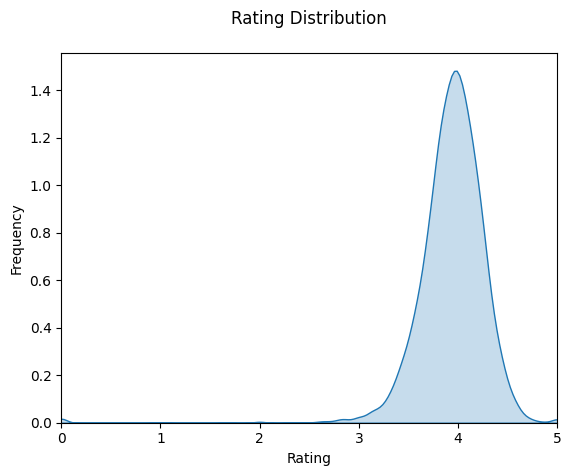

In [1105]:
# ratings distribution
sns.kdeplot(df['average_rating'], shade = True)
plt.title('Rating Distribution\n')
plt.xlim((0, 5))
plt.xlabel('Rating')
plt.ylabel('Frequency')

In [1106]:
df['ratings_count'].describe()

count    1.112700e+04
mean     1.793641e+04
std      1.124794e+05
min      0.000000e+00
25%      1.040000e+02
50%      7.450000e+02
75%      4.993500e+03
max      4.597666e+06
Name: ratings_count, dtype: float64

Text(0, 0.5, 'Frequency')

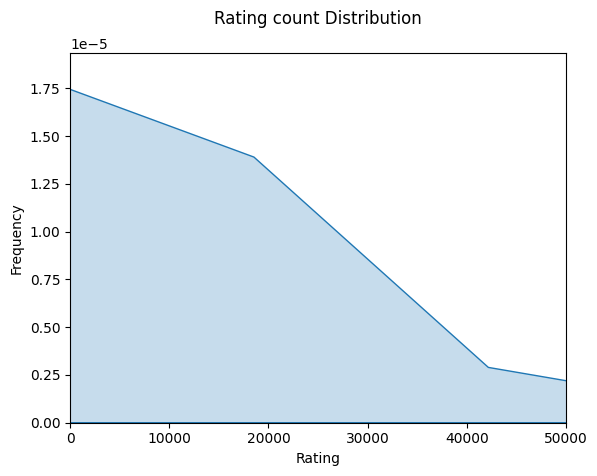

In [1107]:
# ratings distribution
sns.kdeplot(df['ratings_count'], shade = True)
plt.title('Rating count Distribution\n')
plt.xlim((0, 50000))
plt.xlabel('Rating')
plt.ylabel('Frequency')

## Pages

Text(0, 0.5, 'Frequency')

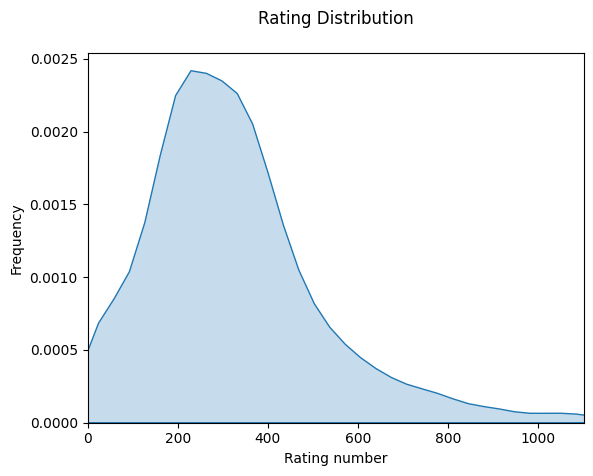

In [1108]:
# ratings distribution
sns.kdeplot(df['num_pages'], shade = True)
plt.title('Rating Distribution\n')
plt.xlim((0, 1100))
plt.xlabel('Rating number')
plt.ylabel('Frequency')

(0.0, 6904.8)

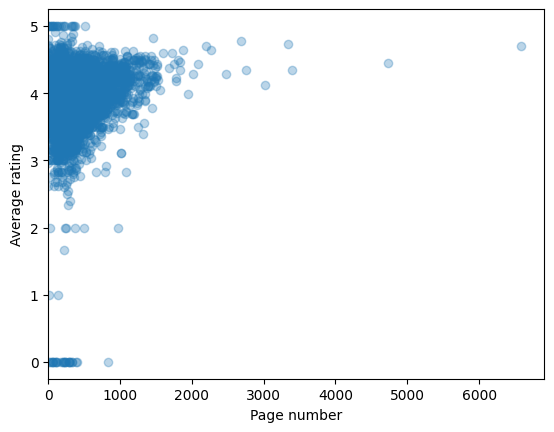

In [1109]:
plt.scatter(df['num_pages'], df['average_rating'], marker='o',alpha = 0.3)
plt.xlabel('Page number')
plt.ylabel('Average rating')
plt.xlim(0)

(0.0, 2000.0)

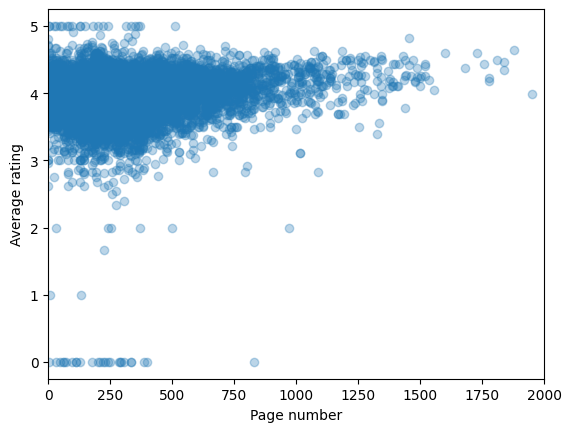

In [1110]:
plt.scatter(df['num_pages'], df['average_rating'], marker='o',alpha = 0.3)
plt.xlabel('Page number')
plt.ylabel('Average rating')
plt.xlim((0,2000))

There is a slight correlation between page number & average. Especially after 500 pages

## Language

In [1111]:
df['language_code'].value_counts()

language_code
eng      8911
en-US    1409
spa       218
en-GB     214
fre       144
ger        99
jpn        46
mul        19
zho        14
grc        11
por        10
en-CA       7
ita         5
enm         3
lat         3
swe         2
rus         2
srp         1
nl          1
msa         1
glg         1
wel         1
ara         1
nor         1
tur         1
gla         1
ale         1
Name: count, dtype: int64

In [1112]:
df_language = pd.DataFrame({'average_rating' : df.groupby(by=['language_code'])['average_rating'].mean(), 'count_rating': df.groupby(by=['language_code'])['language_code'].count() }).reset_index()
df_language.sort_values(by=['count_rating'],ascending=False)

,language_code,average_rating,count_rating
5,eng,3.933546,8911
4,en-US,3.914422,1409
21,spa,3.929312,218
3,en-GB,3.923411,214
7,fre,3.971528,144
8,ger,3.950101,99
13,jpn,4.268696,46
16,mul,4.126316,19
26,zho,4.456429,14
11,grc,3.707273,11


Interesting thing here, where top 6 language which appear the most has around 3.9 average rating. So if we want to be precise in our model we need to predict to within **0.1**

## Publisher / Authors

In [1113]:
(df['publisher'].value_counts() > 5).sum()

364

## Global

<Axes: >

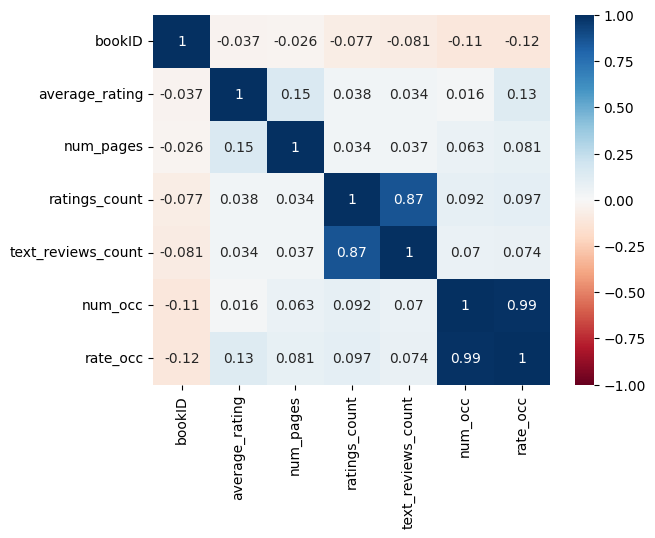

In [1114]:
## Drop qualitative columns for corr matrix 
corr_matrix = df.drop(columns=['title','authors','language_code','publication_date','publisher']).corr()
sns.heatmap(corr_matrix, cmap='RdBu', vmin=-1, vmax=1, annot=True)

# Preprocessing

## Outliers

{'whiskers': [<matplotlib.lines.Line2D at 0x2247fff13d0>,
 'caps': [<matplotlib.lines.Line2D at 0x2247fff2710>,
 'boxes': [<matplotlib.lines.Line2D at 0x2247fff0d10>],
 'medians': [<matplotlib.lines.Line2D at 0x2247fff3790>],
 'fliers': [<matplotlib.lines.Line2D at 0x2247ffd0750>],
 'means': []}

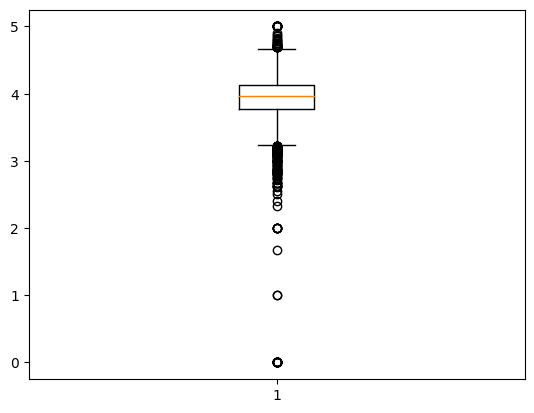

In [1115]:
plt.boxplot(df['average_rating'])

{'whiskers': [<matplotlib.lines.Line2D at 0x22480051250>,
 'caps': [<matplotlib.lines.Line2D at 0x2241e567150>,
 'boxes': [<matplotlib.lines.Line2D at 0x22480050650>],
 'medians': [<matplotlib.lines.Line2D at 0x22480053b50>],
 'fliers': [<matplotlib.lines.Line2D at 0x22480031490>],
 'means': []}

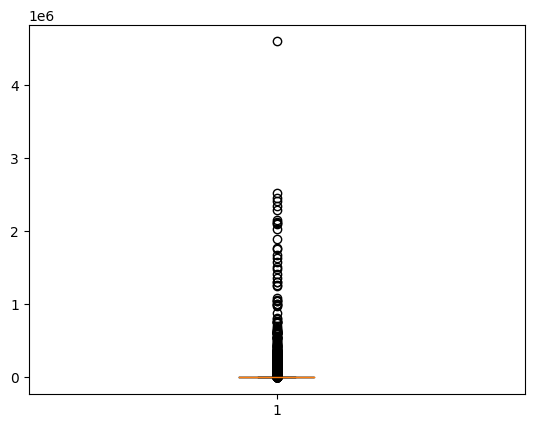

In [1116]:
plt.boxplot(df['ratings_count'])

In [1117]:
print(df.shape)
df= df.drop(df.index[df['ratings_count'] >= 1000000])
print(df.shape)

(11127, 12)
(11097, 12)


{'whiskers': [<matplotlib.lines.Line2D at 0x224800bc750>,
 'caps': [<matplotlib.lines.Line2D at 0x224800bde90>,
 'boxes': [<matplotlib.lines.Line2D at 0x224800aba50>],
 'medians': [<matplotlib.lines.Line2D at 0x224800bf450>],
 'fliers': [<matplotlib.lines.Line2D at 0x224800bfe10>],
 'means': []}

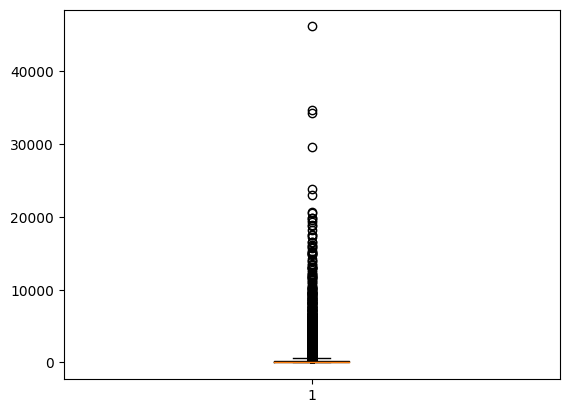

In [1118]:
plt.boxplot(df['text_reviews_count'])

In [1119]:
print(df.shape)
df = df.drop(df.index[df['text_reviews_count'] >= 20000])
print(df.shape)

(11097, 12)
(11089, 12)


{'whiskers': [<matplotlib.lines.Line2D at 0x22480275210>,
 'caps': [<matplotlib.lines.Line2D at 0x22480275550>,
 'boxes': [<matplotlib.lines.Line2D at 0x22480274610>],
 'medians': [<matplotlib.lines.Line2D at 0x22480278050>],
 'fliers': [<matplotlib.lines.Line2D at 0x2248008c890>],
 'means': []}

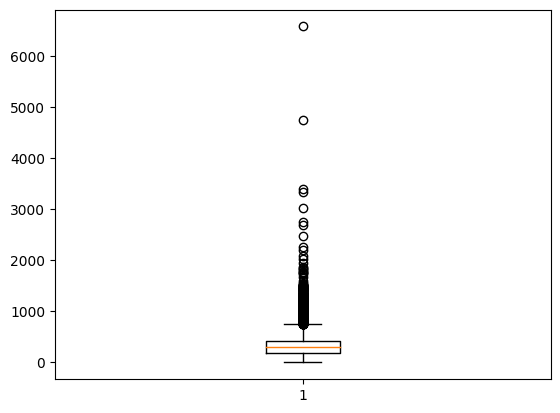

In [1120]:
plt.boxplot(df['num_pages'])

In [1121]:
print(df.shape)
df = df.drop(df.index[df['text_reviews_count'] >= 2000])
print(df.shape)

(11089, 12)
(10527, 12)


## Language

### Modify lang code which appear the least and replace by "others" 

In [1122]:
df['language_code'].value_counts()

language_code
eng      8328
en-US    1398
spa       214
en-GB     213
fre       143
ger        99
jpn        46
mul        19
zho        14
grc        11
por        10
en-CA       7
ita         5
enm         3
lat         3
swe         2
rus         2
srp         1
nl          1
msa         1
glg         1
wel         1
ara         1
nor         1
tur         1
gla         1
ale         1
Name: count, dtype: int64

In [1123]:
top_lang = df['language_code'].value_counts().head(6).index
top_lang

Index(['eng', 'en-US', 'spa', 'en-GB', 'fre', 'ger'], dtype='object', name='language_code')

In [1124]:
mask = ~df['language_code'].isin(top_lang)
df.loc[mask,'language_code'] = 'others'

In [1125]:
df['language_code'].value_counts()

language_code
eng       8328
en-US     1398
spa        214
en-GB      213
fre        143
others     132
ger         99
Name: count, dtype: int64

### One-Hot-Encoding

In [1126]:
df = pd.get_dummies(df
               ,columns = ['language_code']
               ,drop_first = True,
               dtype=int
               )

In [1127]:
df.sample(1)

,bookID,title,authors,average_rating,num_pages,ratings_count,text_reviews_count,publication_date,publisher,num_occ,rate_occ,language_code_en-US,language_code_eng,language_code_fre,language_code_ger,language_code_others,language_code_spa
171,407,Great Jones Street,Don DeLillo,3.48,272,2492,145,1/1/1994,Penguin Books,1,3.48,0,1,0,0,0,0


## Year

In [1128]:
df['publication_date'] = pd.to_datetime(df['publication_date'], format='%m/%d/%Y', errors='coerce')

In [1129]:
df.isnull().sum()

bookID                  0
title                   0
authors                 0
average_rating          0
num_pages               0
ratings_count           0
text_reviews_count      0
publication_date        2
publisher               0
num_occ                 0
rate_occ                0
language_code_en-US     0
language_code_eng       0
language_code_fre       0
language_code_ger       0
language_code_others    0
language_code_spa       0
dtype: int64

In [1130]:
print(df.shape)
df.dropna(inplace=True)
print(df.shape)

(10527, 17)
(10525, 17)


In [1131]:
df['publication_year'] = pd.DatetimeIndex(df['publication_date']).year

In [1132]:
df.drop(columns=['publication_date'],inplace=True)

In [1133]:
df.sample(1)

,bookID,title,authors,average_rating,num_pages,ratings_count,text_reviews_count,publisher,num_occ,rate_occ,language_code_en-US,language_code_eng,language_code_fre,language_code_ger,language_code_others,language_code_spa,publication_year
8179,31371,Becoming a Woman of Beauty and Strength: Esther,Elizabeth George,4.27,160,80,14,Harvest House Publishers,1,4.27,0,1,0,0,0,0,2001


## Qualitative data to label 

In [1134]:
## Label encode title 
le = preprocessing.LabelEncoder()
df['title'] = le.fit_transform(df['title'])
df['title'].value_counts().head(10)

title
6645    8
2       8
7514    8
2850    7
8035    7
194     7
593     7
5490    6
5690    6
8129    6
Name: count, dtype: int64

In [1135]:
## Label encode authors
df['authors'] = le.fit_transform(df['title'])
df['authors'].value_counts().head(10)

authors
6645    8
2       8
7514    8
2850    7
8035    7
194     7
593     7
5490    6
5690    6
8129    6
Name: count, dtype: int64

In [1136]:
## Label encode authors
df['publisher'] = le.fit_transform(df['publisher'])
df['publisher'].value_counts().head(10)

publisher
2086    293
1457    225
1473    172
1206    144
183     136
877     105
1542    105
186     100
868     100
2055     87
Name: count, dtype: int64

## Split train / test

In [1137]:
df.dtypes

bookID                    int64
title                     int32
authors                   int64
average_rating          float64
num_pages                 int64
ratings_count             int64
text_reviews_count        int64
publisher                 int32
num_occ                   int64
rate_occ                float64
language_code_en-US       int32
language_code_eng         int32
language_code_fre         int32
language_code_ger         int32
language_code_others      int32
language_code_spa         int32
publication_year          int32
dtype: object

In [1138]:
# ## test wih less features
# df.drop(columns=['title','authors','publisher','publication_year'])

In [1139]:
y = df.pop('average_rating')

X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['bookID']), y, test_size=0.3, random_state=42)

In [1140]:
y_train.count()

7367

In [1141]:
y_test.count()

3158

# Models

In [1142]:
global_result = pd.DataFrame(columns=['model name','RMSE','mae','r2_score'])

## Baseline  (Predict mean average rating)

In [1143]:
len(y_test)

3158

In [1144]:
mean_ratings = y_test.mean().round(2)
y_pred = np.full((len(y_test)), mean_ratings)
y_pred

array([3.93, 3.93, 3.93, ..., 3.93, 3.93, 3.93])

### Metrics

In [1145]:
# calculate errors
errors = mean_squared_error(y_test,y_pred)
rmse = math.sqrt(errors)
print(f'RMSE : {rmse}')
mae = mean_absolute_error(y_test,y_pred)
print(f'mae : {mae}')
r2 = r2_score(y_test,y_pred).round(2)
print(f'r2_score : {r2}')


# Create dictionnary to aggregte all result 
dict = {'model name' : 'Baseline','RMSE':rmse,'mae':mae,'r2_score':r2 }
global_result.loc[len(global_result)] = pd.Series(data=dict,index=dict.keys())

RMSE : 0.3742581008196514
mae : 0.2374889170360988
r2_score : -0.0


## Linear Regression

In [1146]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [1147]:
y_pred = lr.predict(X_test)

### Metrics

In [1148]:
# calculate errors
errors = mean_squared_error(y_test,y_pred)
rmse = math.sqrt(errors)
print(f'RMSE : {rmse}')
mae = mean_absolute_error(y_test,y_pred)
print(f'mae : {mae}')
r2 = r2_score(y_test,y_pred).round(2)
print(f'r2_score : {r2}')

# Create dictionnary to aggregte all result 
dict = {'model name' : 'Linear regression','RMSE':rmse,'mae':mae,'r2_score':r2 }
global_result.loc[len(global_result)] = pd.Series(data=dict,index=dict.keys())

pred = pd.DataFrame({'Actual': y_test.tolist(), 'Predicted': y_pred.tolist()}).head(25)
print(pred.head(25))

RMSE : 0.17278789256667193
mae : 0.08716692756518477
r2_score : 0.79
    Actual  Predicted
0     3.79   3.828499
1     3.65   3.727375
2     4.03   4.005403
3     4.08   4.055504
4     4.29   4.177626
5     4.39   4.233809
6     3.59   3.682819
7     4.30   4.172776
8     3.24   3.430927
9     4.22   4.138707
10    3.69   3.755524
11    3.93   3.916415
12    4.01   3.987333
13    3.72   3.782265
14    3.69   3.750400
15    4.36   4.250333
16    4.36   4.230369
17    3.82   3.471124
18    4.08   4.036097
19    3.90   3.859448
20    3.88   3.854348
21    4.33   4.210183
22    4.04   4.001603
23    4.11   4.057782
24    4.24   4.144825


## Random Forest

In [1149]:
parameters = {
    'n_estimators': [50, 100, 200],
    'max_depth': [7, 10, 12, 15],
    'min_samples_split': [2,5],
    'min_samples_leaf': [5, 10, 15]
}
regr = RandomForestRegressor(random_state=0)

In [1150]:
clf = GridSearchCV(estimator = regr, param_grid = parameters,cv=3,verbose=2, n_jobs = -1)

In [1151]:
clf.fit(X_train,y_train)

Fitting 3 folds for each of 72 candidates, totalling 216 fits


GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=0), n_jobs=-1,
             param_grid={'max_depth': [7, 10, 12, 15],
                         'min_samples_leaf': [5, 10, 15],
                         'min_samples_split': [2, 5],
                         'n_estimators': [50, 100, 200]},
             verbose=2)

In [1152]:
clf.best_params_

{'max_depth': 15,
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'n_estimators': 50}

In [1153]:
best_rf = clf.best_estimator_
y_pred = clf.predict(X_test)

### Metrics

In [1154]:
importance_feature = pd.DataFrame(best_rf.feature_importances_,index=X_train.columns,columns=['Importance']).sort_values(by=['Importance'],ascending=False)
importance_feature.sort_values(by=['Importance'],ascending=True,inplace=True)
importance_feature

,Importance
language_code_fre,0.000000e+00
language_code_ger,0.000000e+00
language_code_others,0.000000e+00
language_code_spa,0.000000e+00
language_code_en-US,4.305689e-09
language_code_eng,7.118070e-06
text_reviews_count,5.666825e-04
authors,7.326214e-04
title,8.608285e-04
publisher,9.879156e-04


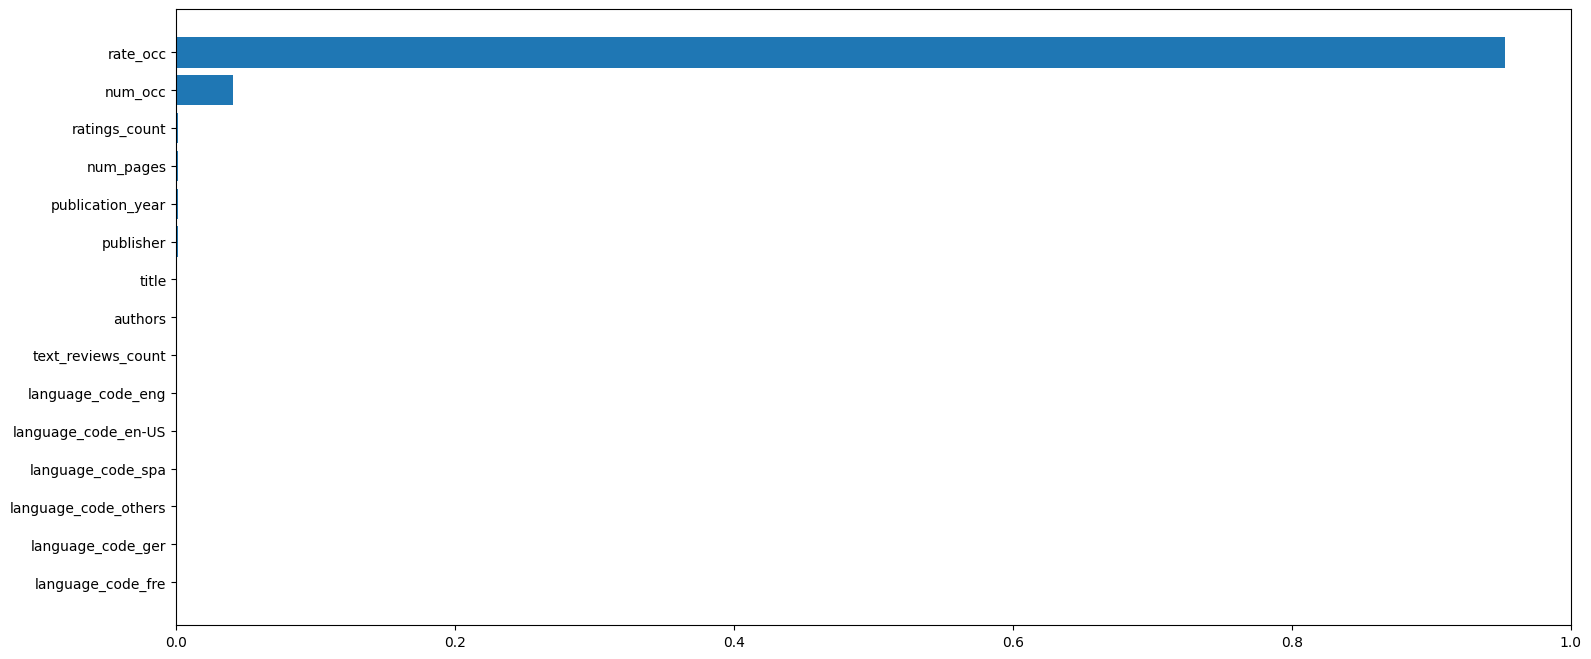

In [1155]:
plt.figure(figsize=(18,8))
plt.barh(y=importance_feature.index,width=importance_feature.values.reshape((-1,)))
plt.show()

In [1156]:
### Metrics
# calculate errors
errors = mean_squared_error(y_test,y_pred)
rmse = math.sqrt(errors)
print(f'RMSE : {rmse}')
mae = mean_absolute_error(y_test,y_pred)
print(f'mae : {mae}')
r2 = r2_score(y_test,y_pred).round(2)
print(f'r2_score : {r2.round(2)}')

# Create dictionnary to aggregte all result 
dict = {'model name' : 'Random Forest','RMSE':rmse,'mae':mae,'r2_score':r2 }
global_result.loc[len(global_result)] = pd.Series(data=dict,index=dict.keys())

pred = pd.DataFrame({'Actual': y_test.tolist(), 'Predicted': y_pred.tolist()}).head(25)
print(pred.head(5))

RMSE : 0.03744018735998382
mae : 0.005850230124434224
r2_score : 0.99
   Actual  Predicted
0    3.79       3.79
1    3.65       3.65
2    4.03       4.03
3    4.08       4.08
4    4.29       4.29


In [1157]:
pred = pd.DataFrame({'Actual': y_test.tolist(), 'Predicted': y_pred.tolist()}).head(25)
pred.head(5)

,Actual,Predicted
0,3.79,3.79
1,3.65,3.65
2,4.03,4.03
3,4.08,4.08
4,4.29,4.29


## XGBoost

In [1158]:
xgb = XGBRegressor()

In [1159]:
parameters = {'nthread':[6],
              'objective':['reg:linear'],
              'learning_rate': [0.01,.03], #so called `eta` value
              'max_depth': [5,7,15],
              'subsample': [0.5],
              'n_estimators': [500,1000]}

In [1160]:
xgb_grid = GridSearchCV(xgb,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)

In [1161]:
xgb_grid.fit(X_train,y_train)

Fitting 2 folds for each of 12 candidates, totalling 24 fits
[15:10:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=2,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None, ...),
             n_jobs=5,
             param_grid={'learning_rate': [0.01, 0.03], 'max_depth': [5, 7, 15],
                         'n_estimators': [500, 1000], 'nthread': [6],
                         'objective': ['reg:linear'], 'subsample': [0.5]},
             verbose=True)

In [1162]:
print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

0.9956205788450772
{'learning_rate': 0.03, 'max_depth': 5, 'n_estimators': 1000, 'nthread': 6, 'objective': 'reg:linear', 'subsample': 0.5}


In [1163]:
optimal_xgb = xgb_grid.best_estimator_

In [1164]:
y_pred = optimal_xgb.predict(X_test)

In [1165]:
### Metrics
# calculate errors
errors = mean_squared_error(y_test,y_pred)
rmse = math.sqrt(errors)
print(f'RMSE : {rmse}')
mae = mean_absolute_error(y_test,y_pred)
print(f'mae : {mae}')
r2 = r2_score(y_test,y_pred).round(2)
print(f'r2_score : {r2.round(2)}')

# Create dictionnary to aggregte all result 
dict = {'model name' : 'XGBoost','RMSE':rmse,'mae':mae,'r2_score':r2 }
global_result.loc[len(global_result)] = pd.Series(data=dict,index=dict.keys())

pred = pd.DataFrame({'Actual': y_test.tolist(), 'Predicted': y_pred.tolist()}).head(25)

RMSE : 0.01118717124884569
mae : 0.00191056061455488
r2_score : 1.0


# Global result

In [1166]:
global_result

,model name,RMSE,mae,r2_score
0,Baseline,0.374258,0.237489,-0.0
1,Linear regression,0.172788,0.087167,0.79
2,Random Forest,0.03744,0.00585,0.99
3,XGBoost,0.011187,0.001911,1.0


In [1167]:
0.011187

0.011187